<a href="https://colab.research.google.com/github/gizemkaratas/Customer_Churn/blob/main/Customer_Churn_telco.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **ML ile Müşteri Churn Tahmini**

---



In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df=pd.read_csv('Telco-Customer-Churn.csv')

Sütun Adı	Açıklama
* CustomerId	Müşteri İd’si
* Gender	Cinsiyet
* SeniorCitizen	Müşterinin yaşlı olup olmadığı (1, 0)
* Partner	Müşterinin bir ortağı olup olmadığı (Evet, Hayır)
* Dependents	Müşterinin bakmakla yükümlü olduğu kişiler olup olmadığı (Evet, Hayır)
* Tenure	Müşterinin şirkette kaldığı ay sayısı
* PhoneService	Müşterinin telefon hizmeti olup olmadığı (Evet, Hayır)
* MultipleLines	Müşterinin birden fazla hattı olup olmadığı (Evet, Hayır, Telefon hizmeti yok)
* InternetService	Müşterinin internet servis sağlayıcısı (DSL, Fiber optik, Hayır)
* OnlineSecurity	Müşterinin çevrimiçi güvenliğinin olup olmadığı (Evet, Hayır, İnternet hizmeti yok)
* OnlineBackup	Müşterinin online yedeğinin olup olmadığı (Evet, Hayır, İnternet hizmeti yok)
* DeviceProtection	Müşterinin cihaz korumasına sahip olup olmadığı (Evet, Hayır, İnternet hizmeti yok)
* TechSupport	Müşterinin teknik destek alıp almadığı (Evet, Hayır, İnternet hizmeti yok)
* StreamingTV	Müşterinin TV yayını olup olmadığı (Evet, Hayır, İnternet hizmeti yok)
* StreamingMovies	Müşterinin film akışı olup olmadığı (Evet, Hayır, İnternet hizmeti yok)
* Contract	Müşterinin sözleşme süresi (Aydan aya, Bir yıl, İki yıl)
* PaperlessBilling	Müşterinin kağıtsız faturası olup olmadığı (Evet, Hayır)
* PaymentMethod	Müşterinin ödeme yöntemi (Elektronik çek, Posta çeki, Banka havalesi (otomatik), Kredi kartı (otomatik))
* MonthlyCharges	Müşteriden aylık olarak tahsil edilen tutar
* TotalCharges	Müşteriden tahsil edilen toplam tutar
* Churn	Müşterinin kullanıp kullanmadığı (Evet veya Hayır)

In [4]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [5]:
df.shape

(7043, 21)

In [6]:
df.describe()

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


In [7]:
df.isnull().sum()


,0
customerID,0
gender,0
SeniorCitizen,0
Partner,0
Dependents,0
tenure,0
PhoneService,0
MultipleLines,0
InternetService,0
OnlineSecurity,0


# **Değişken Analizi ve Hata Düzeltimi:**

In [25]:
#Değişken analizinin yapılması

def grab_col_names(dataframe, cat_th=10, car_th=20):
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]
    print(f"Gözlemler: {dataframe.shape[0]}")
    print(f"Değişkenler: {dataframe.shape[1]}")
    print(f'Kategorik Sütunlar: {len(cat_cols)}')
    print(f'Sayısal Sütunlar: {len(num_cols)}')
    print(f'Yüksek Kardinaliteli Kategorik Sütunlar: {len(cat_but_car)}')
    print(f'Sayısal Görünen Kategorik Sütunlar: {len(num_but_cat)}')
    return cat_cols, cat_but_car, num_cols

cat_cols, cat_but_car, num_cols = grab_col_names(df)

Gözlemler: 7043
Değişkenler: 21
Kategorik Sütunlar: 17
Sayısal Sütunlar: 2
Yüksek Kardinaliteli Kategorik Sütunlar: 2
Sayısal Görünen Kategorik Sütunlar: 1


In [26]:
# tip hatası olan değişkenleri düzeltilmesi

import pandas as pd
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')


In [18]:
#Bağımlı ve Bağımsız Değişkenlerin belirlenmesi
X=df.drop('Churn',axis=1)
y=df['Churn']

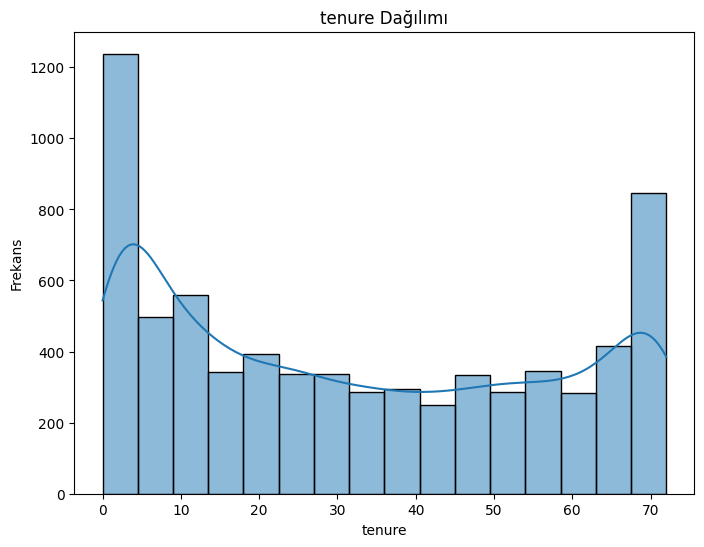

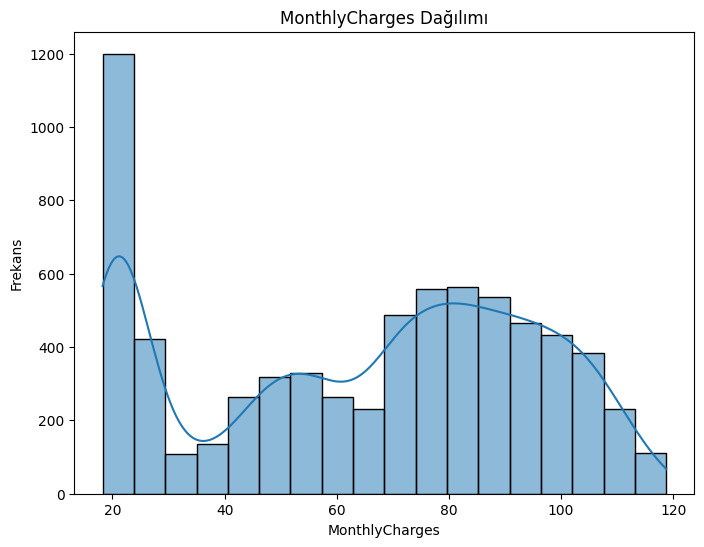

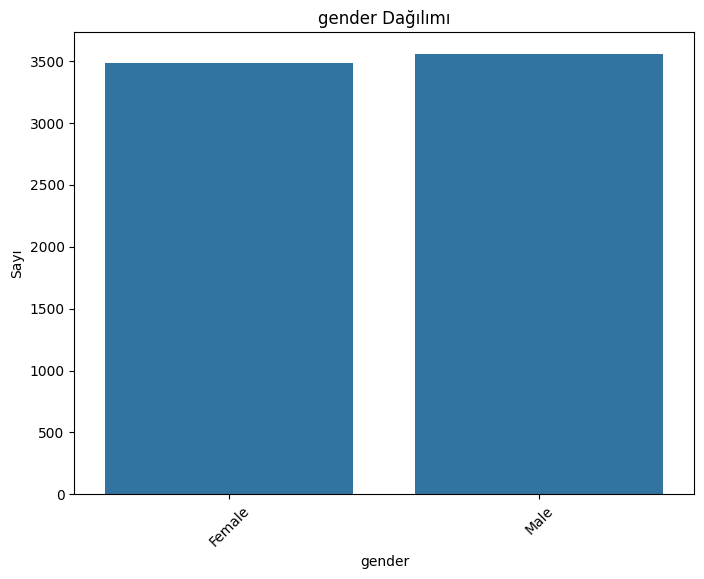

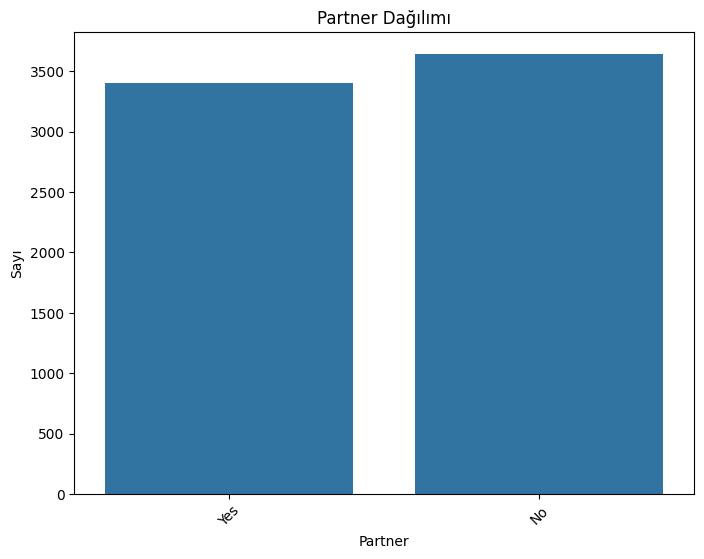

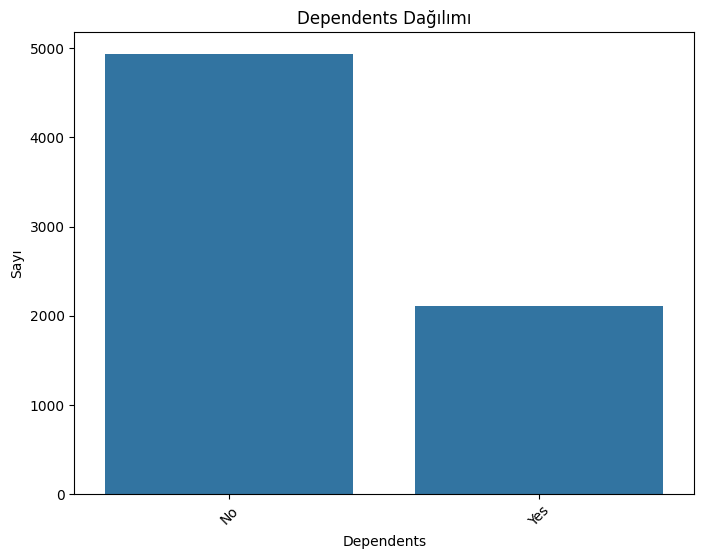

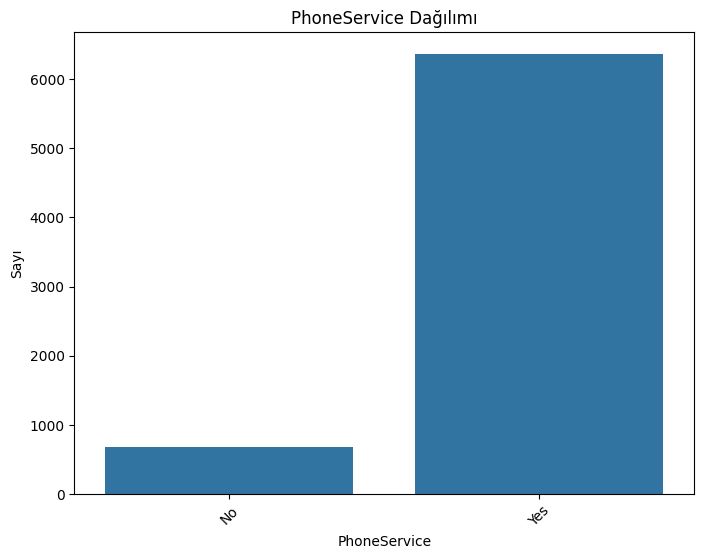

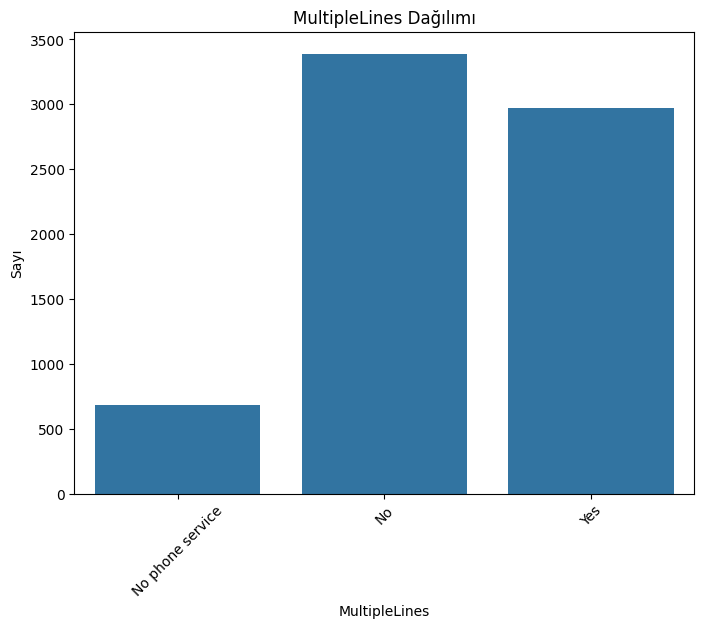

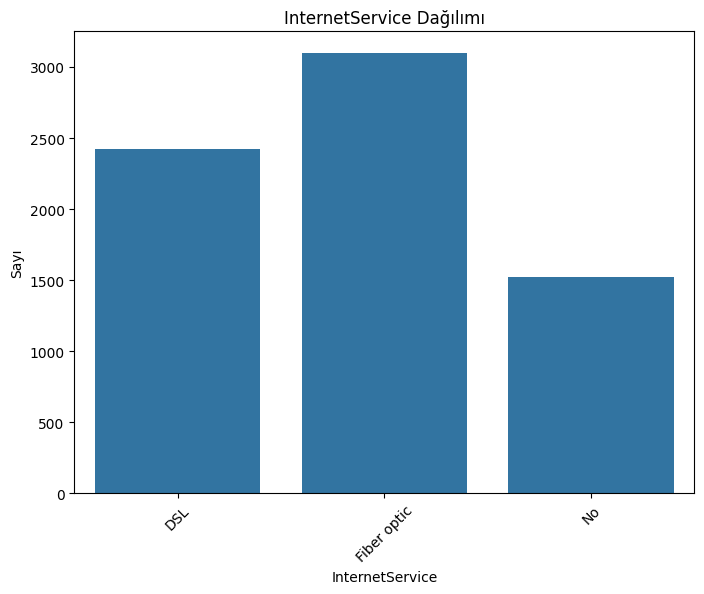

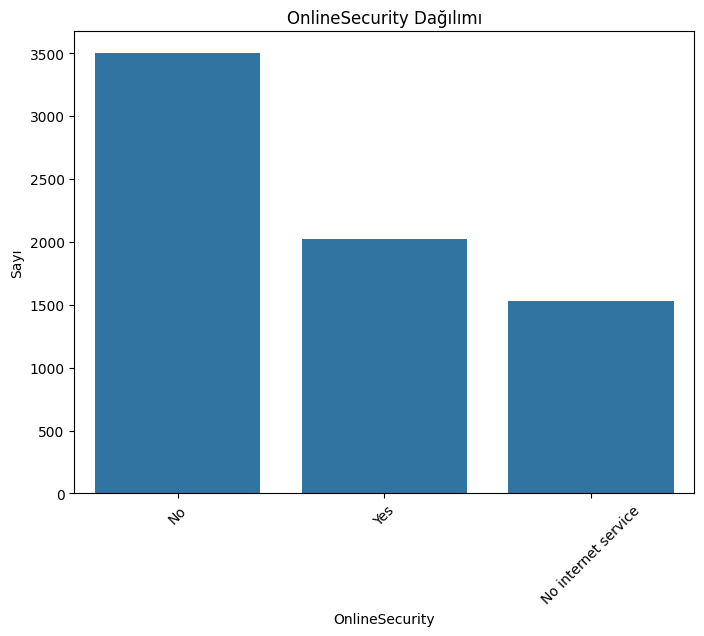

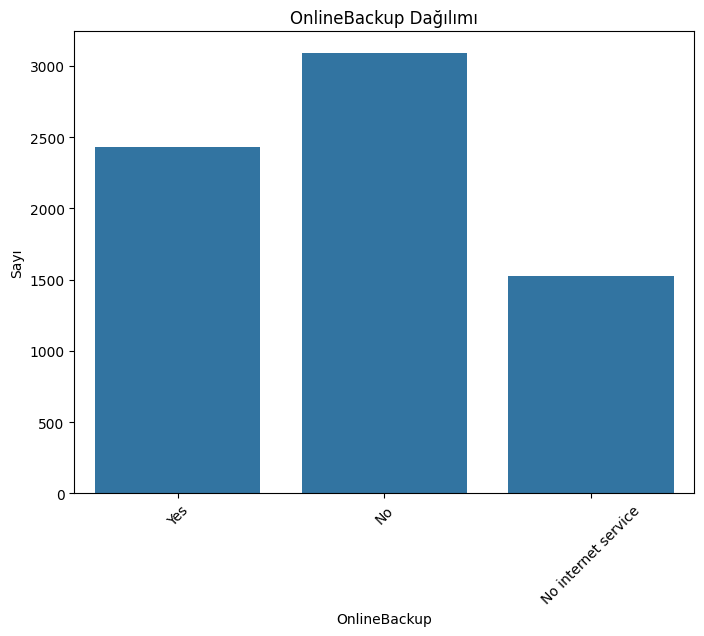

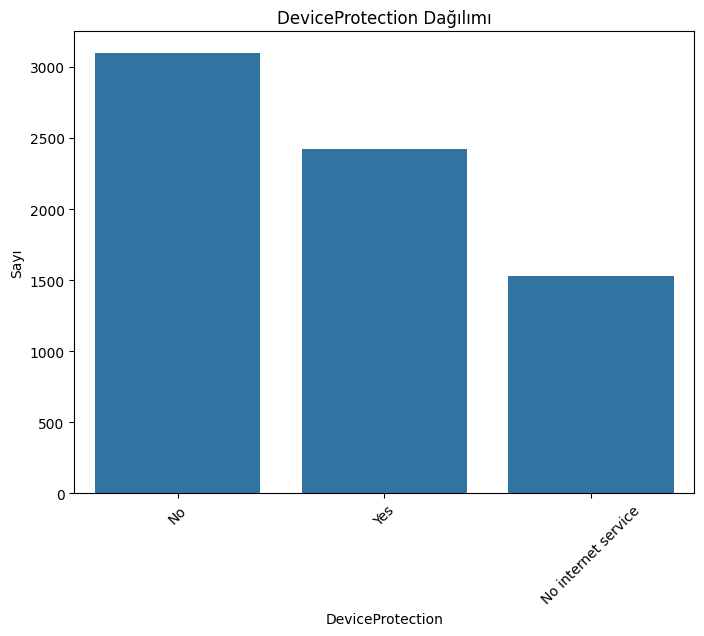

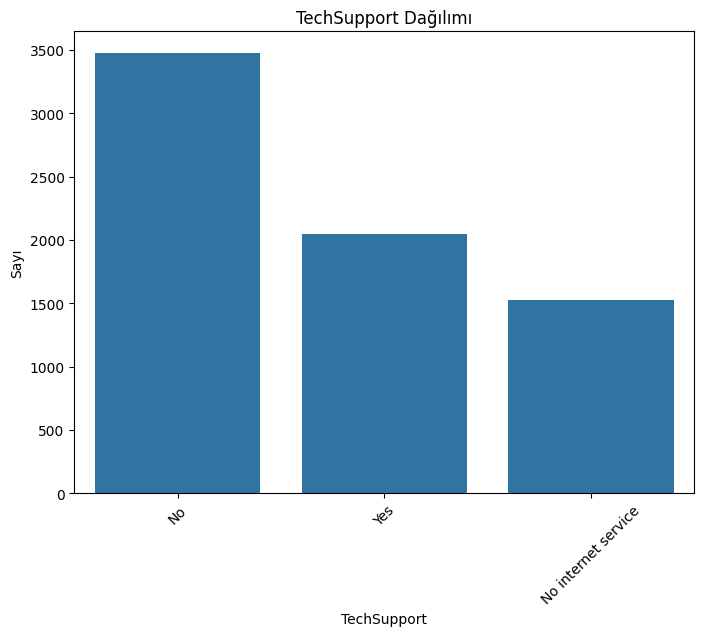

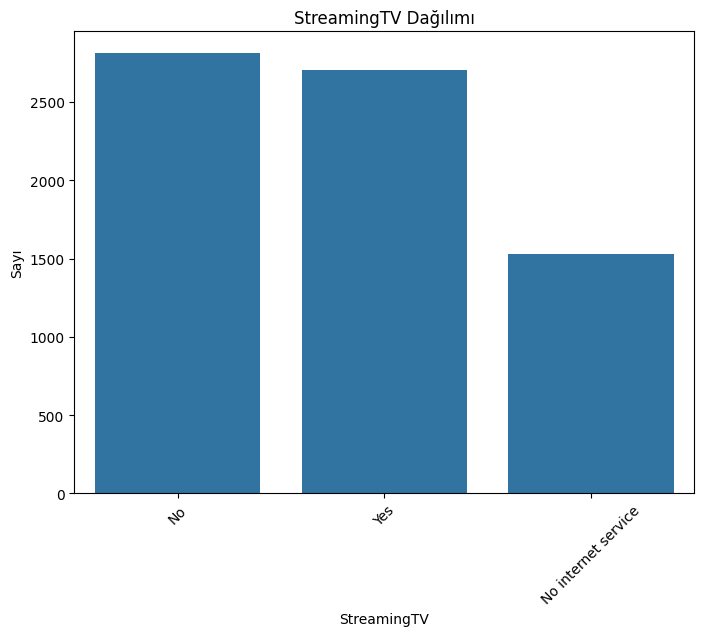

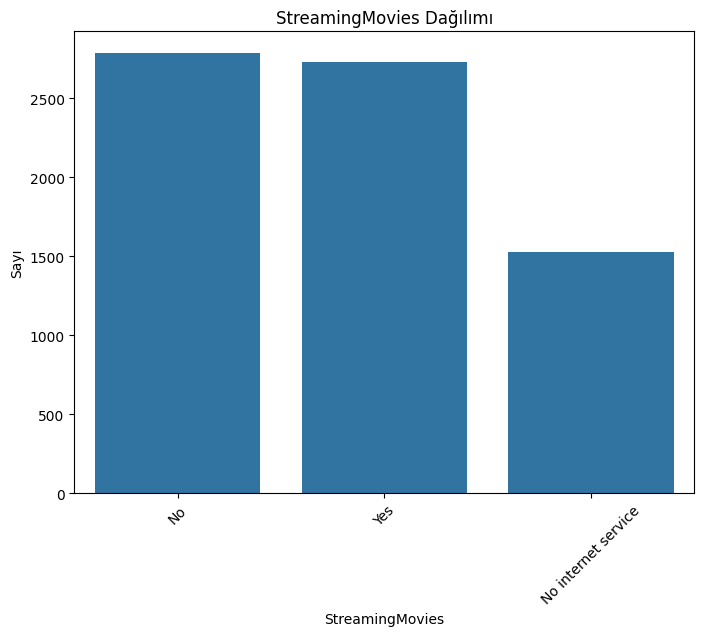

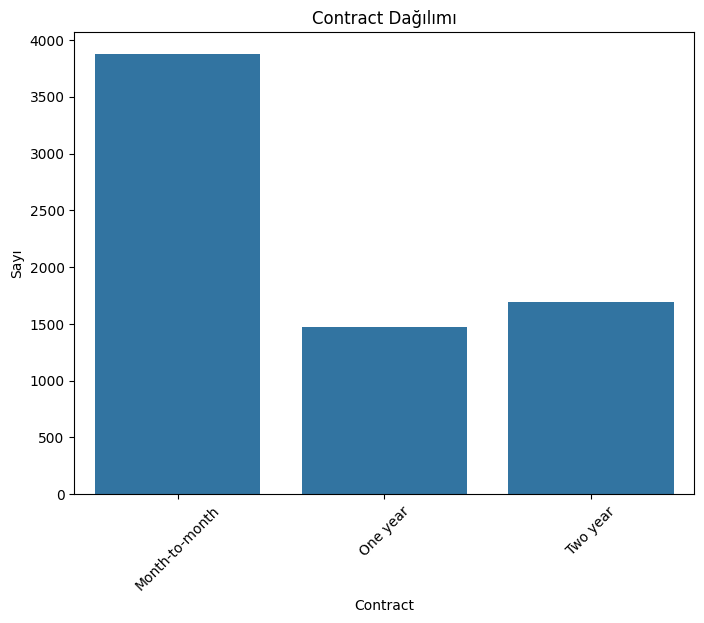

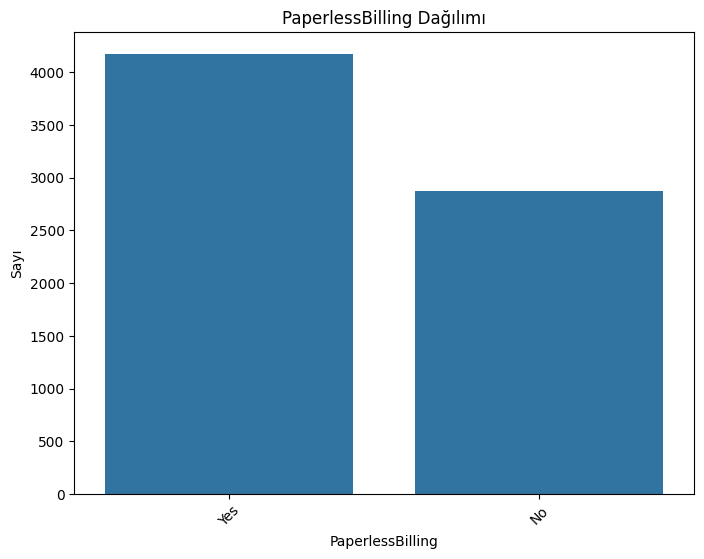

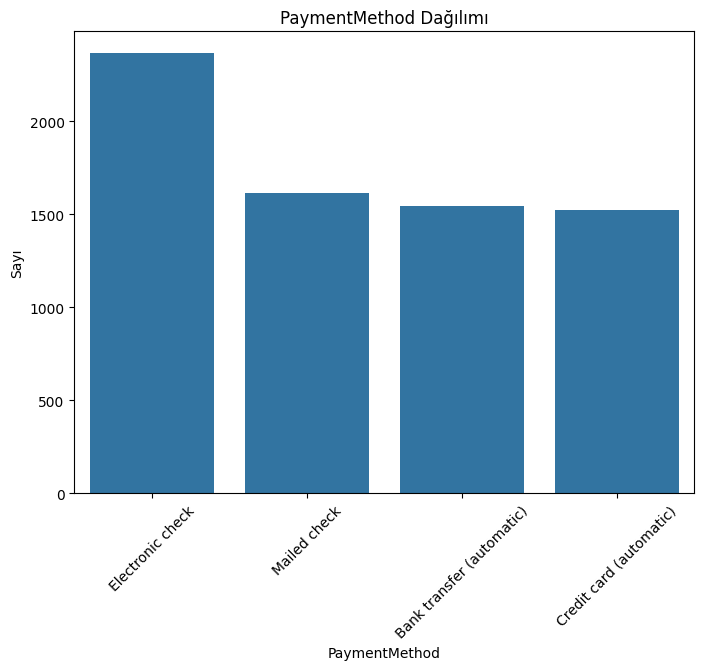

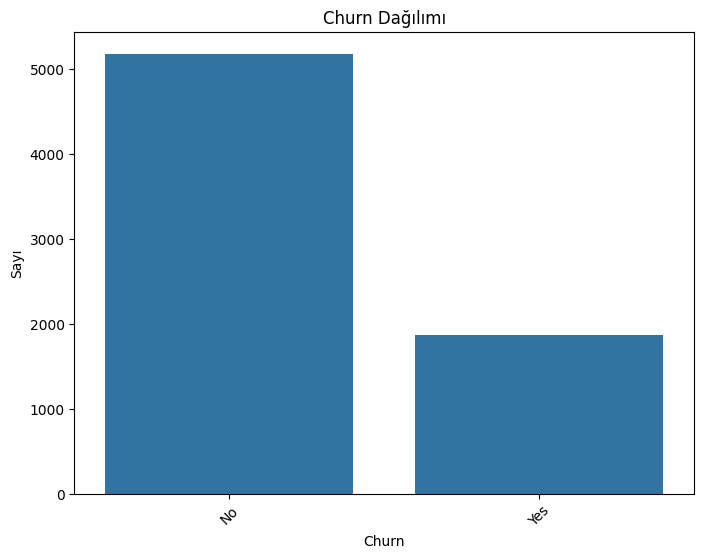

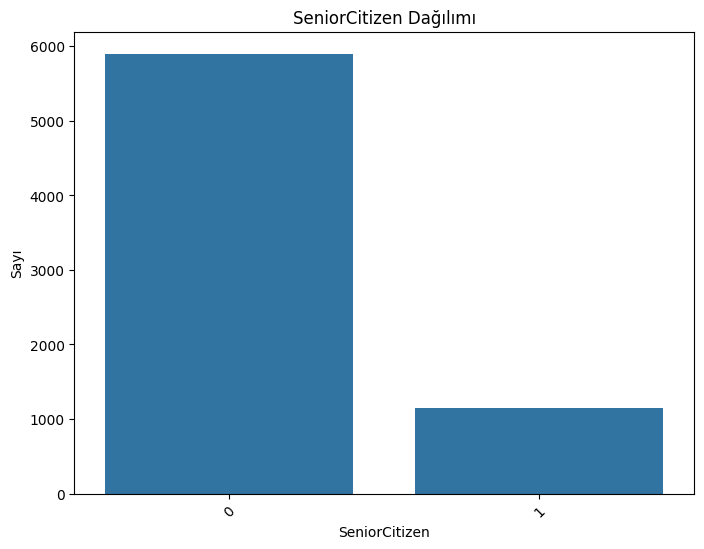

In [27]:
# Numerik ve kategorik değişkenlerin veri içindeki dağılımının gözlemlenmesi:

import matplotlib.pyplot as plt
# Numerik değişkenlerin dağılımını inceleyelim
for col in num_cols:
    plt.figure(figsize=(8, 6))
    sns.histplot(df[col], kde=True)
    plt.title(f"{col} Dağılımı")
    plt.xlabel(col)
    plt.ylabel("Frekans")
    plt.show()

# Kategorik değişkenlerin dağılımını inceleyelim
for col in cat_cols:
    plt.figure(figsize=(8, 6))
    sns.countplot(x=df[col])
    plt.title(f"{col} Dağılımı")
    plt.xlabel(col)
    plt.ylabel("Sayı")
    plt.xticks(rotation=45)
    plt.show()


In [28]:
# No phone service geçen verileri No olarak değiştirilmesş ve  No internet service geçen verileri de No ile değiştirilmesi

df.replace('No phone service','No',inplace=True)
df.replace('No internet service','No',inplace=True)
df.head()


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


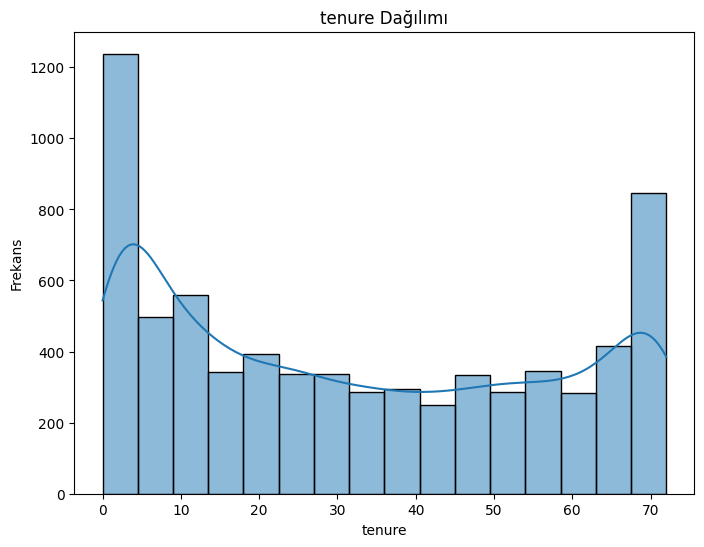

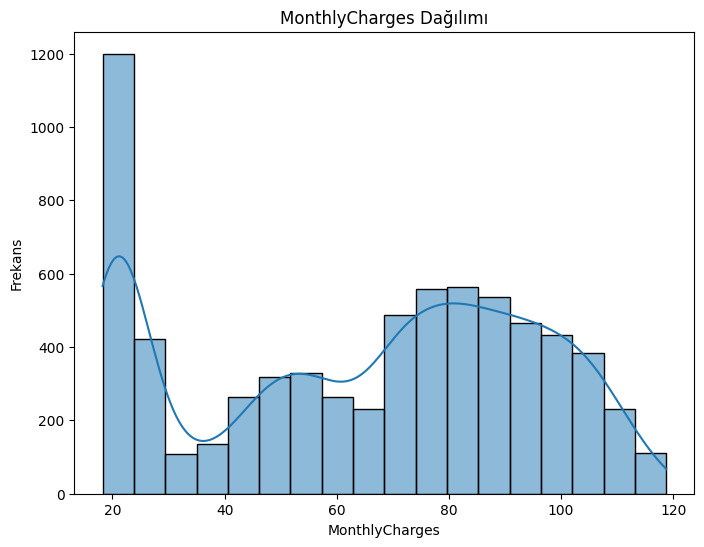

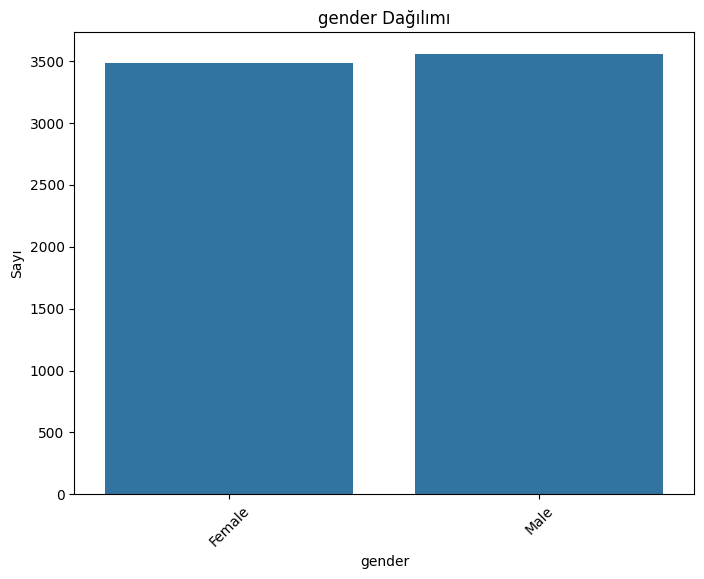

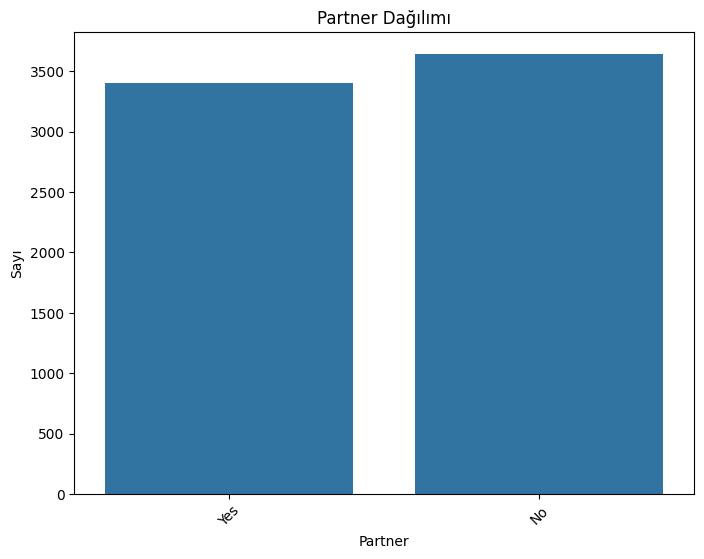

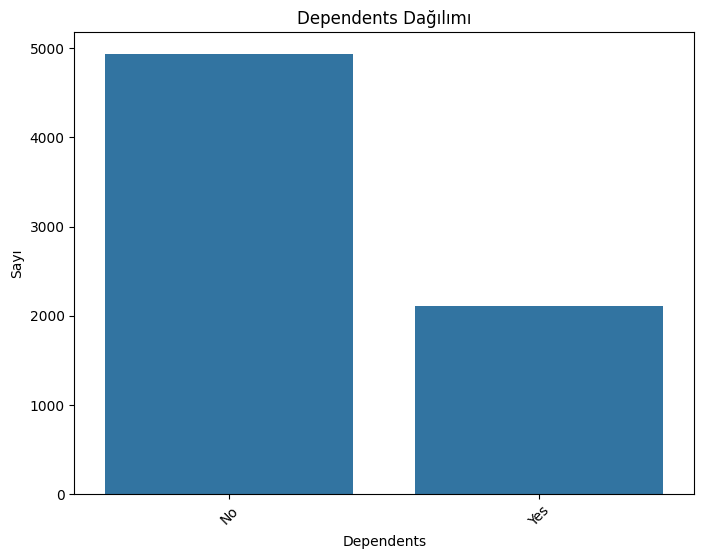

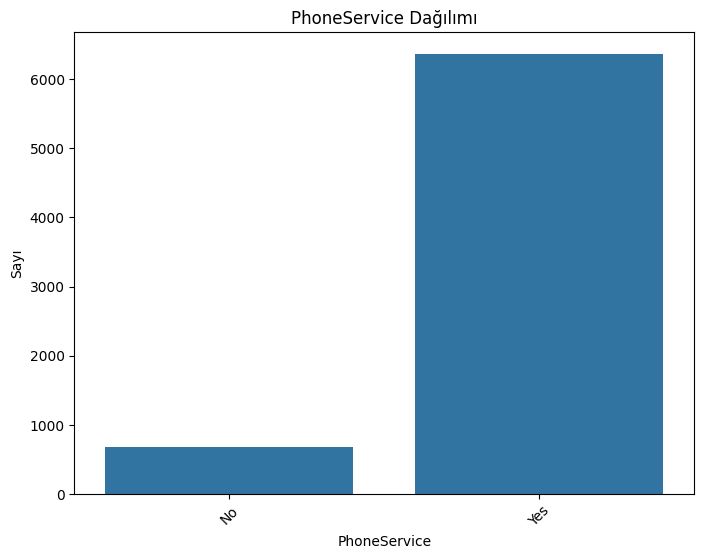

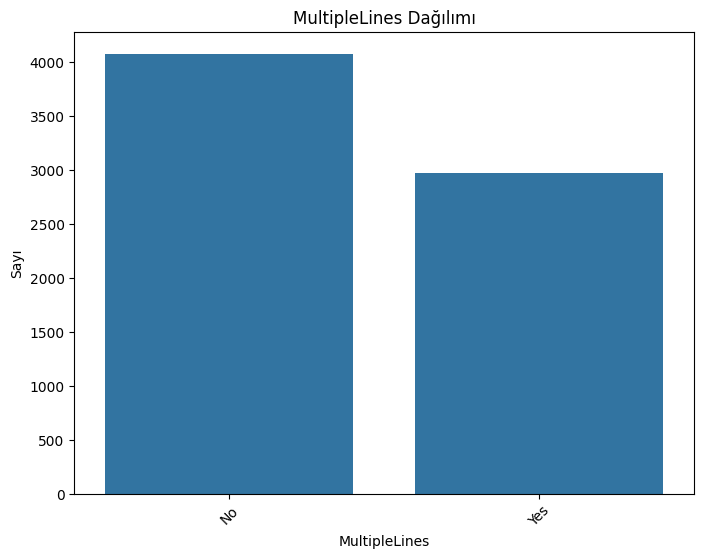

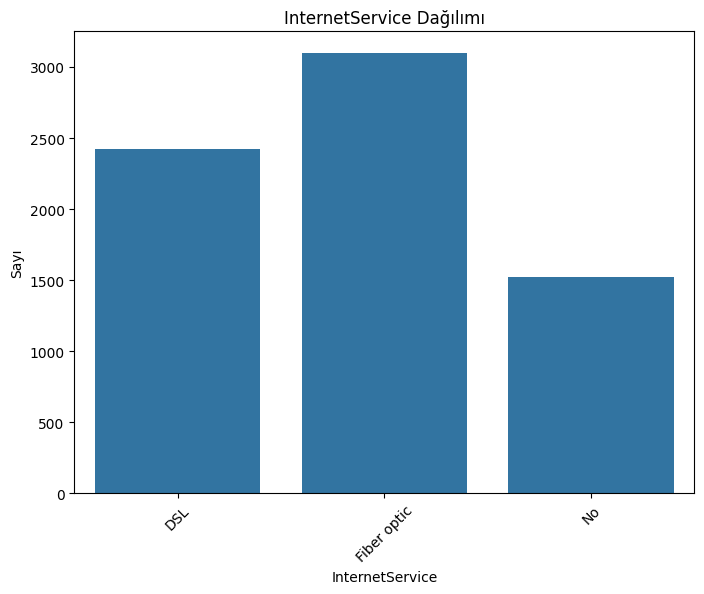

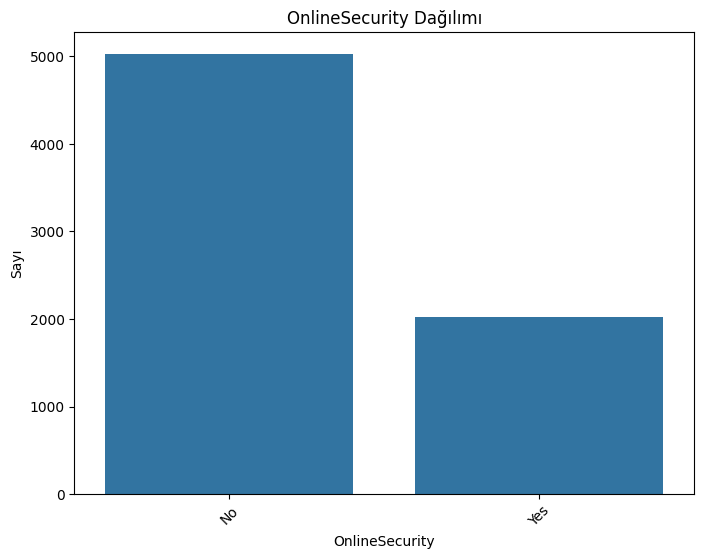

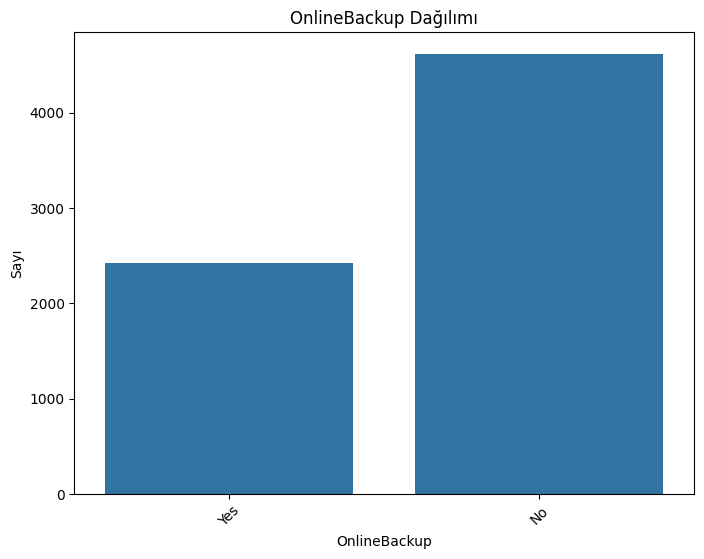

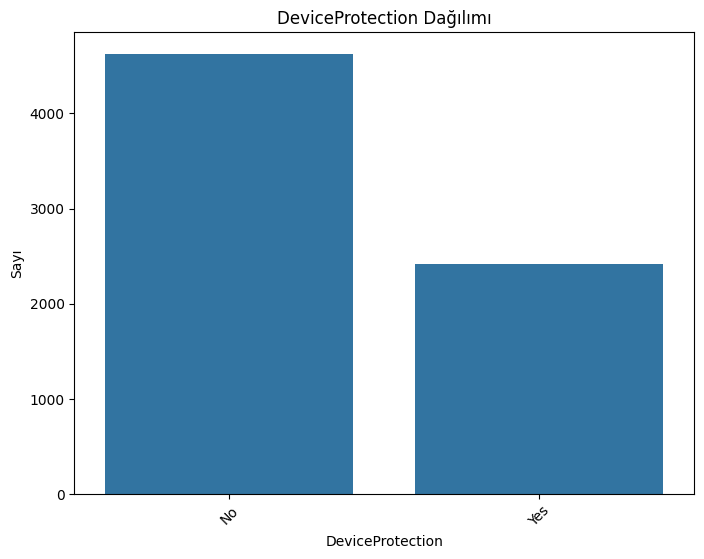

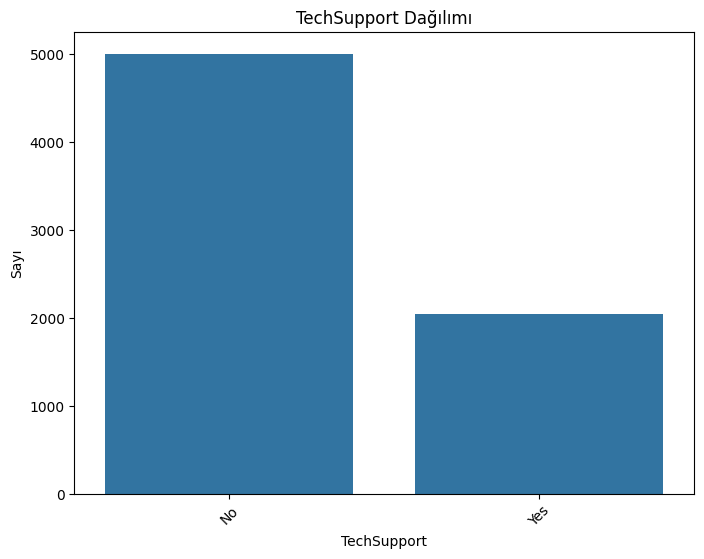

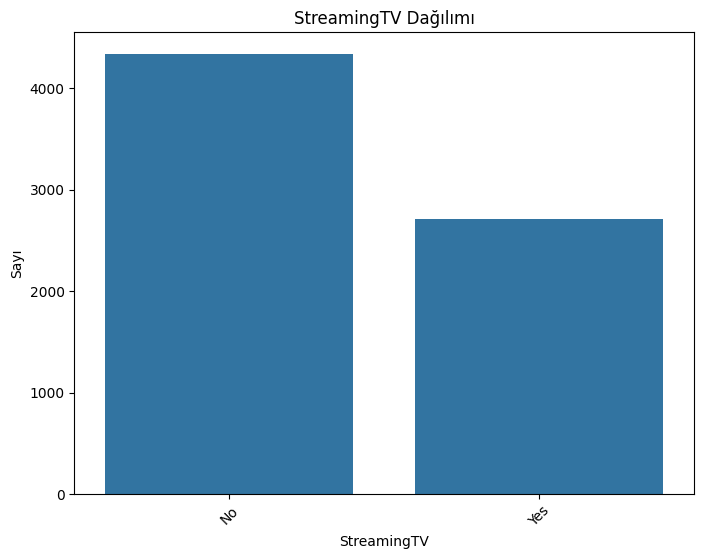

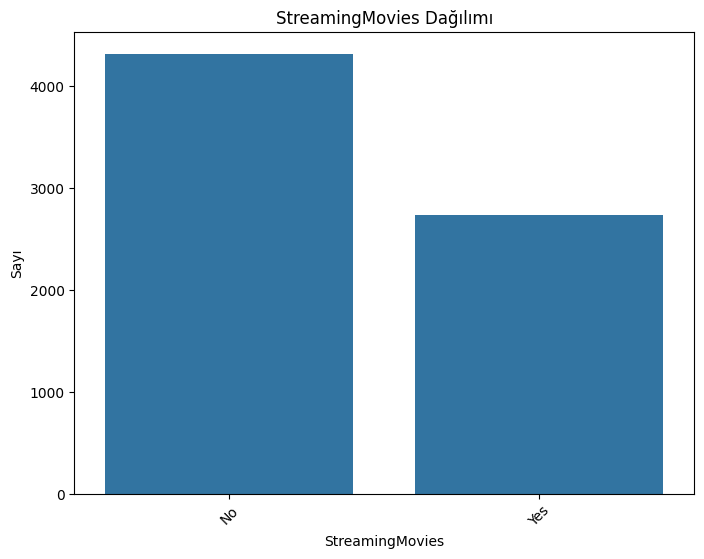

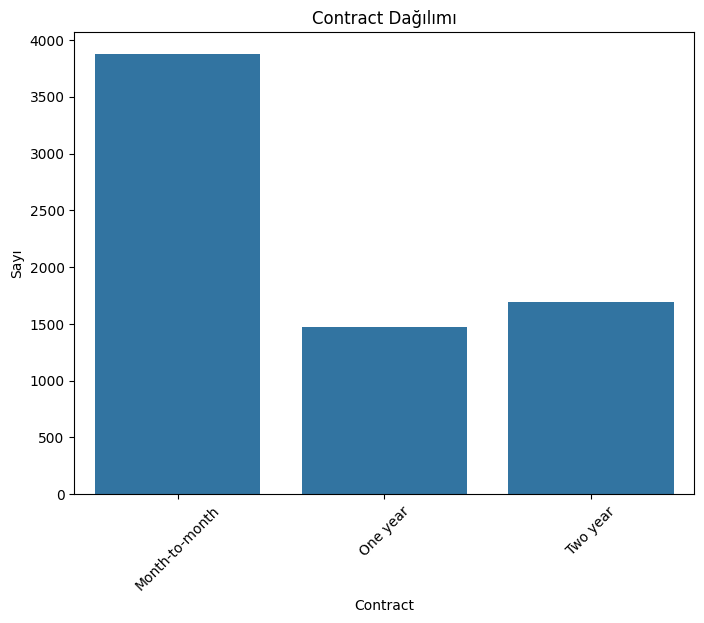

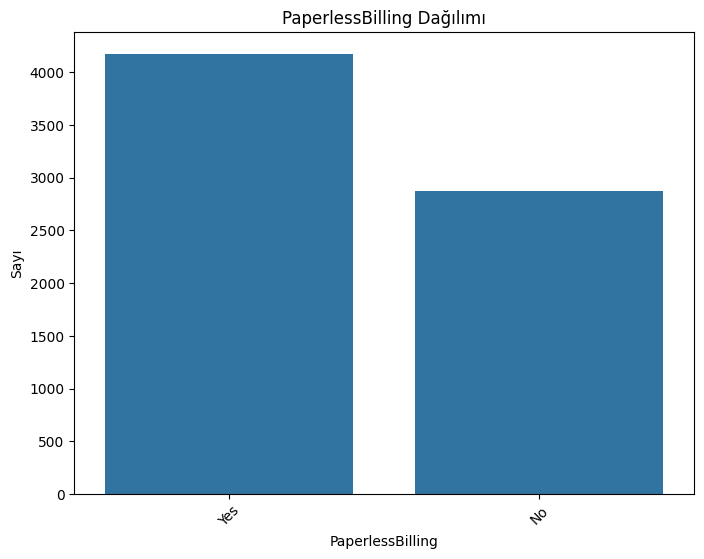

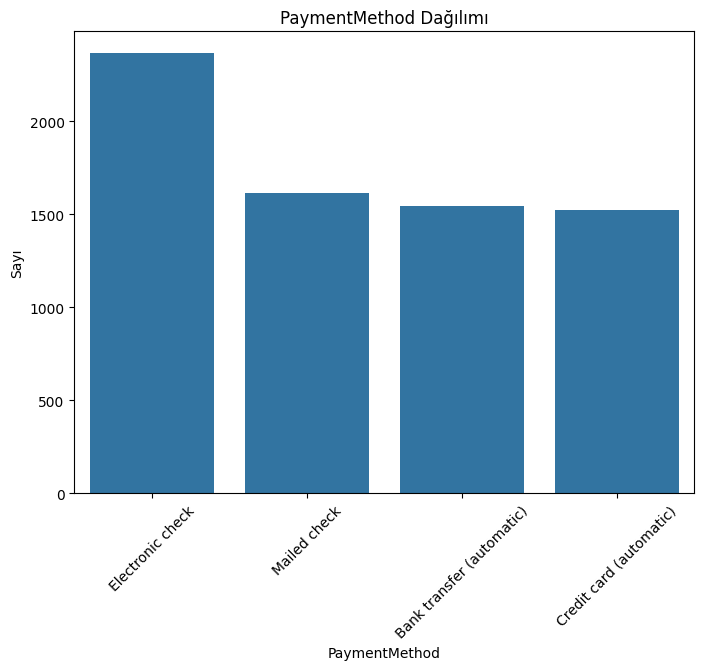

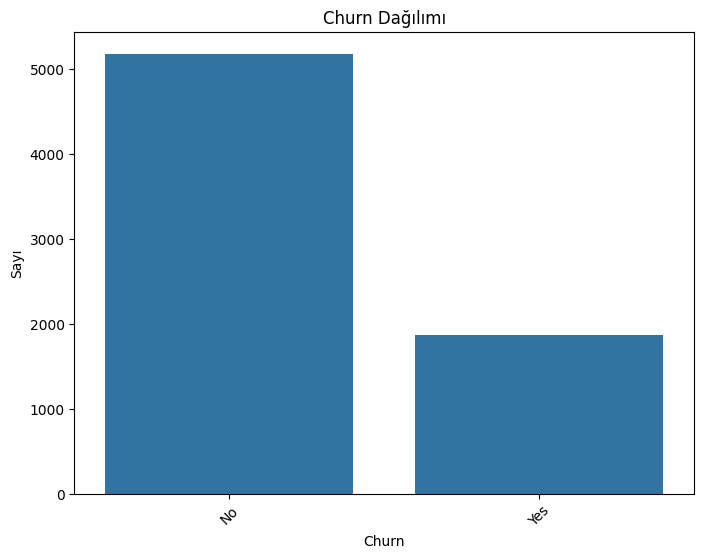

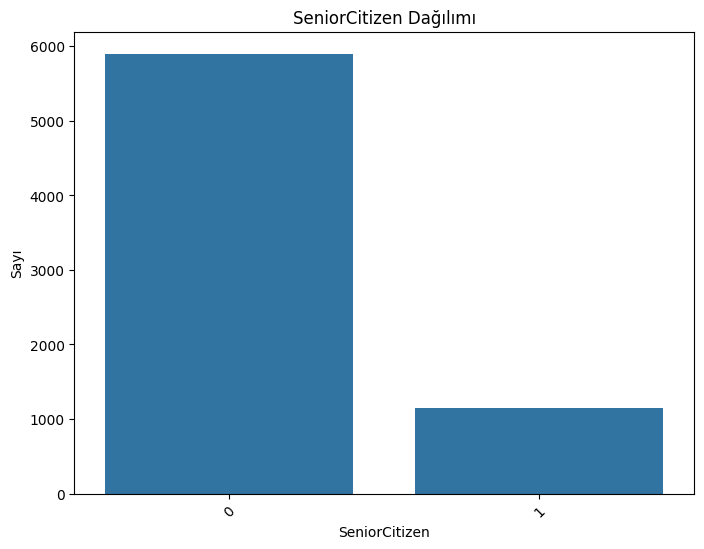

In [29]:
# Tekrar Numerik ve kategorik değişkenlerin veri içindeki dağılımını gözlemleyiniz.

import matplotlib.pyplot as plt
# Numerik değişkenlerin dağılımını inceleyelim
for col in num_cols:
    plt.figure(figsize=(8, 6))
    sns.histplot(df[col], kde=True)
    plt.title(f"{col} Dağılımı")
    plt.xlabel(col)
    plt.ylabel("Frekans")
    plt.show()

# Kategorik değişkenlerin dağılımını inceleyelim
for col in cat_cols:
    plt.figure(figsize=(8, 6))
    sns.countplot(x=df[col])
    plt.title(f"{col} Dağılımı")
    plt.xlabel(col)
    plt.ylabel("Sayı")
    plt.xticks(rotation=45)
    plt.show()

In [10]:
# prompt: kategorik verilerin sayısala dönüştürülmesi

import numpy as np
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
for column in X.columns:
  if X[column].dtype==np.number:
    continue
  X[column]=le.fit_transform(X[column])


<ipython-input-10-b44bc9f38766>:7: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  if X[column].dtype==np.number:
<ipython-input-10-b44bc9f38766>:7: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  if X[column].dtype==np.number:
<ipython-input-10-b44bc9f38766>:7: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  if X[column].dtype==np.number:
<ipython-input-10-b44bc9f38766>:7: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  if X[column].dtype==np.number:
<ipython-input-10-b44bc9f38766>:7: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The cu

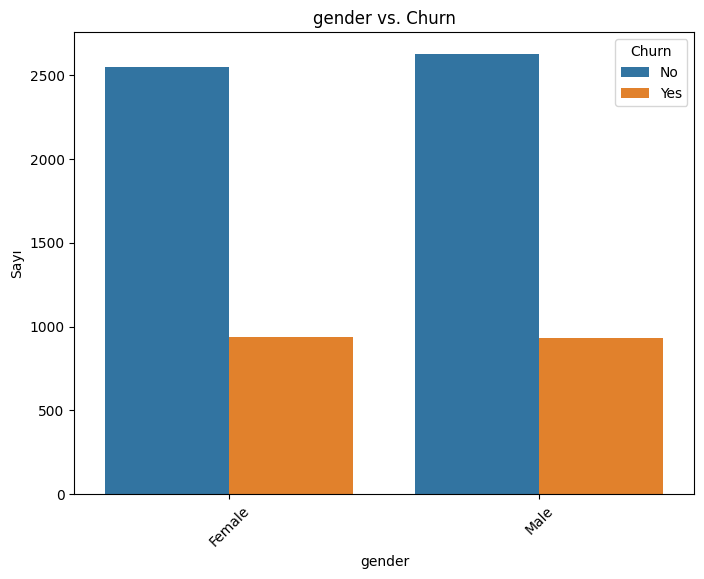

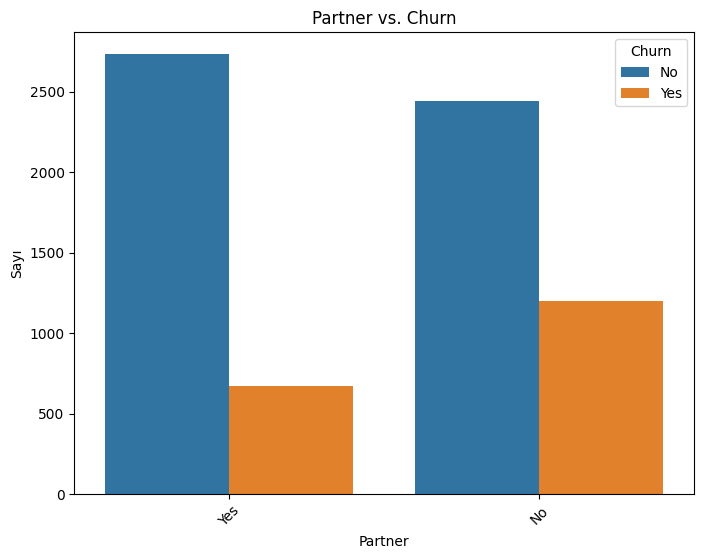

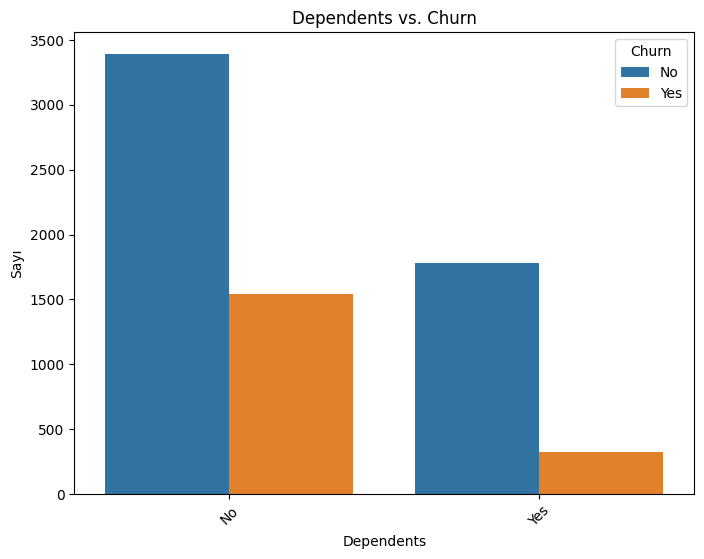

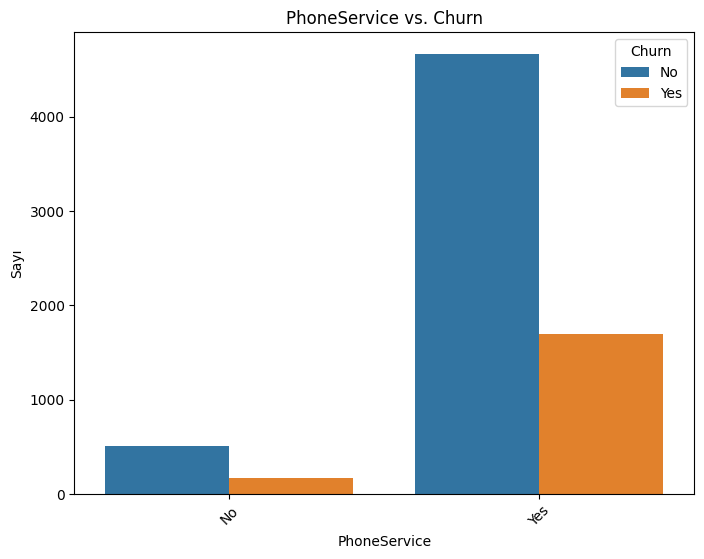

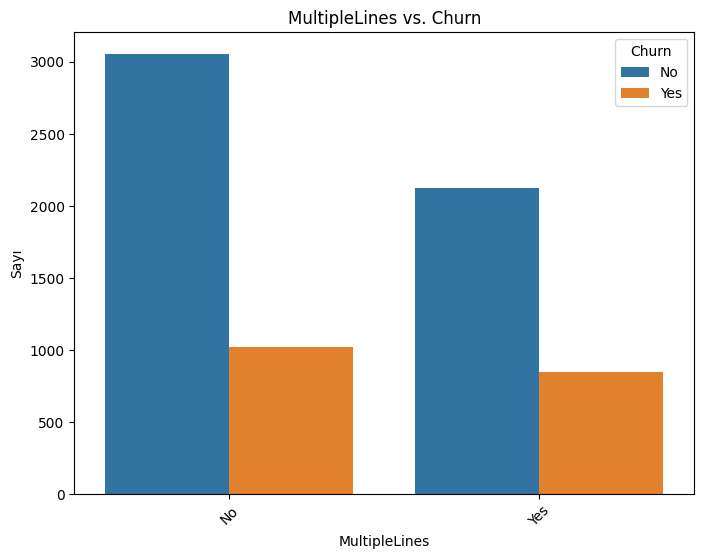

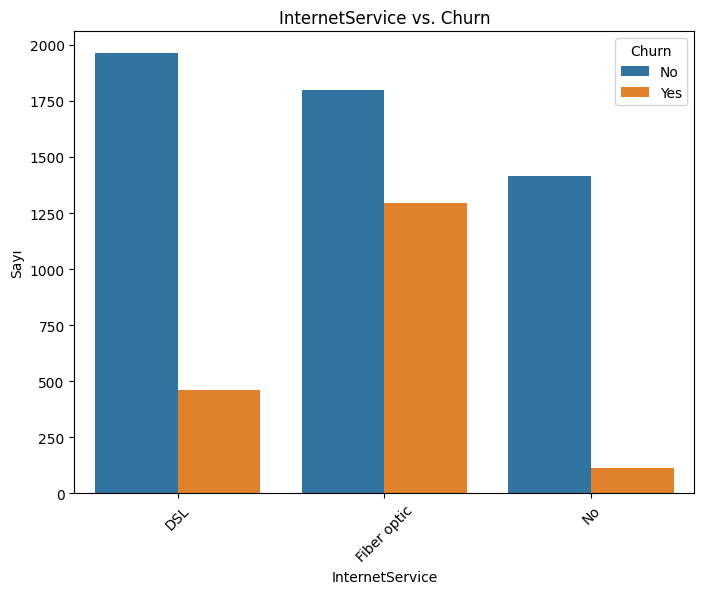

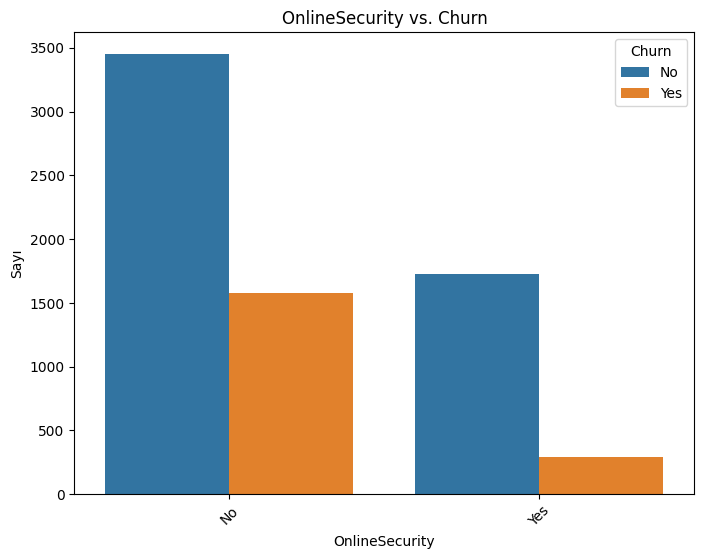

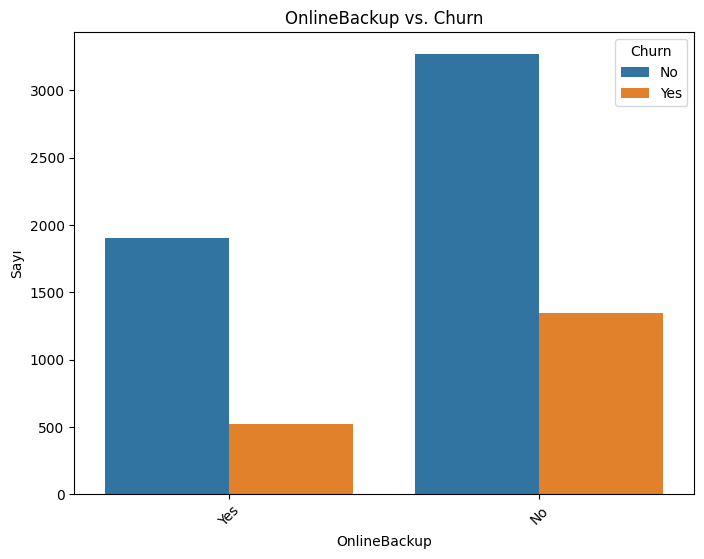

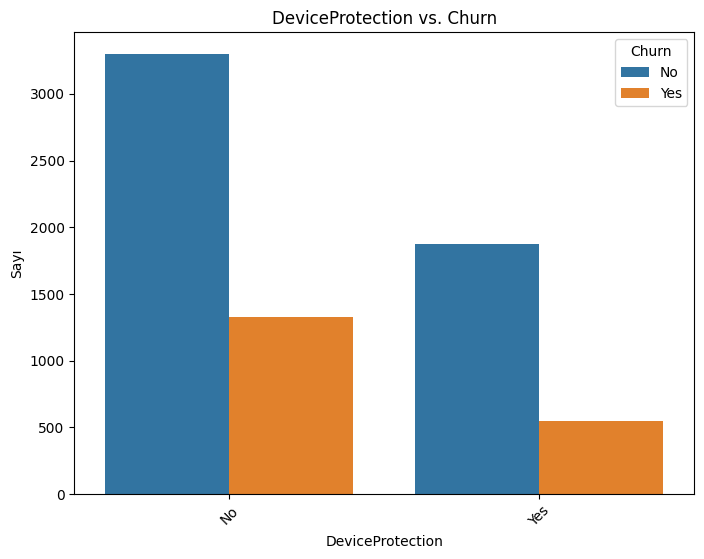

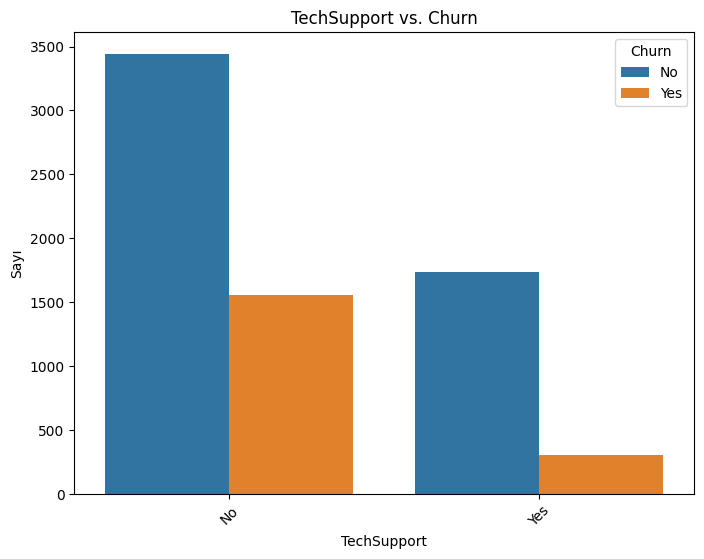

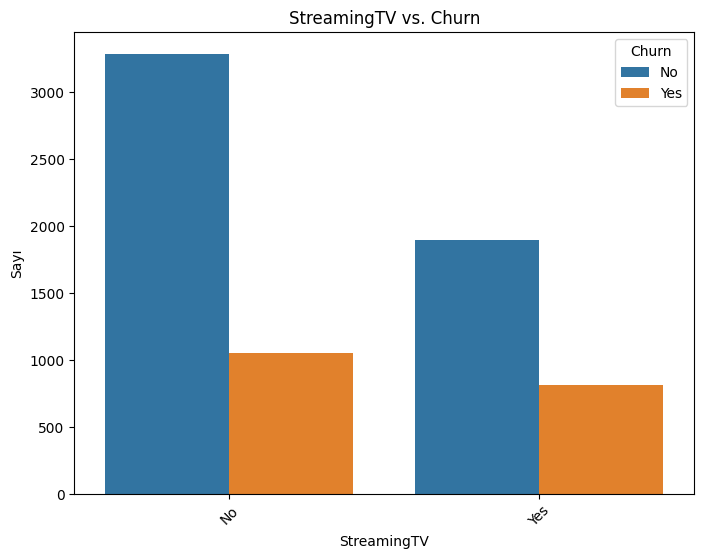

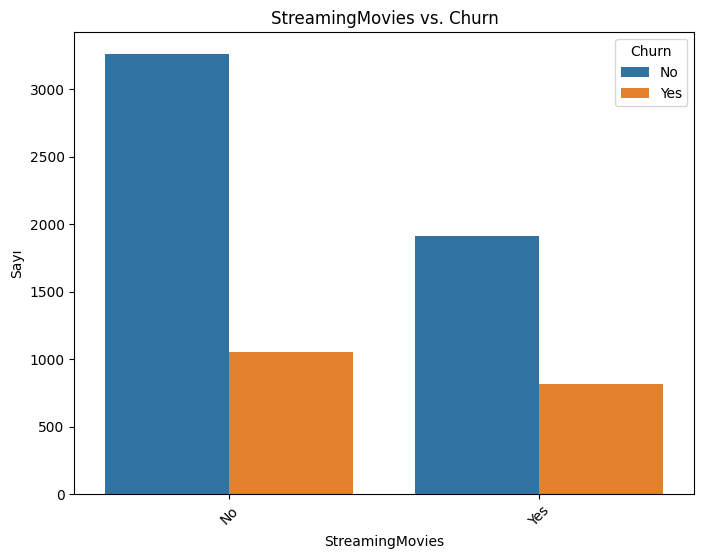

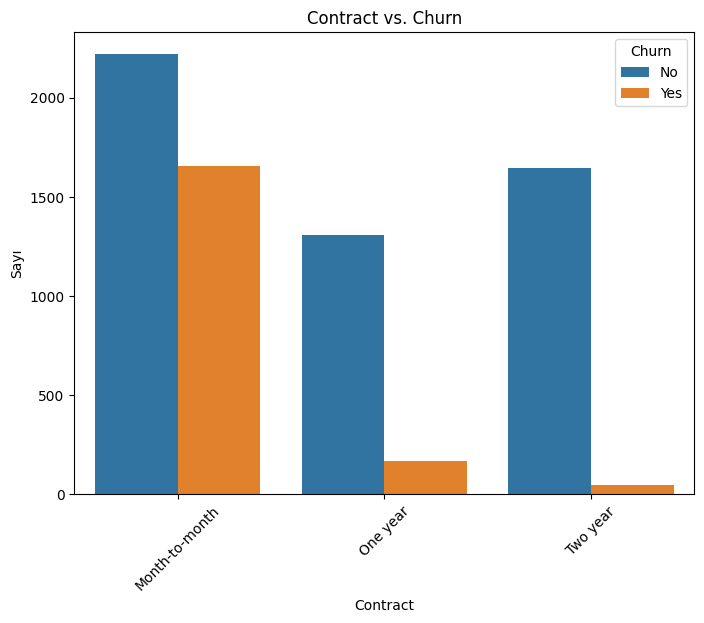

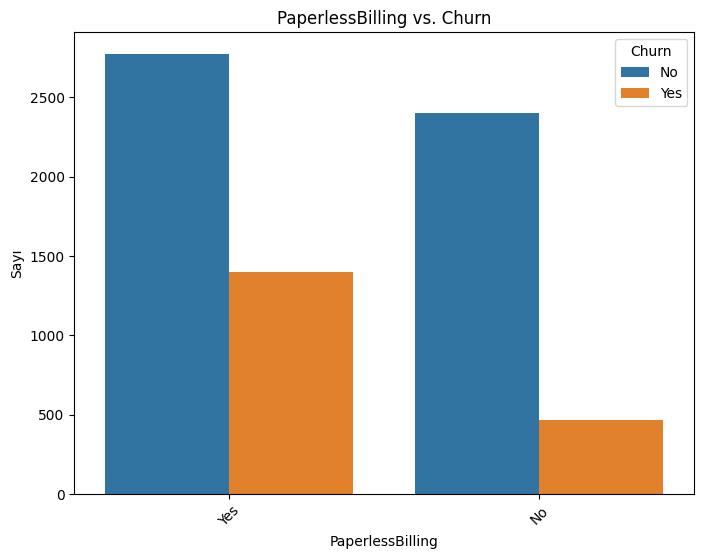

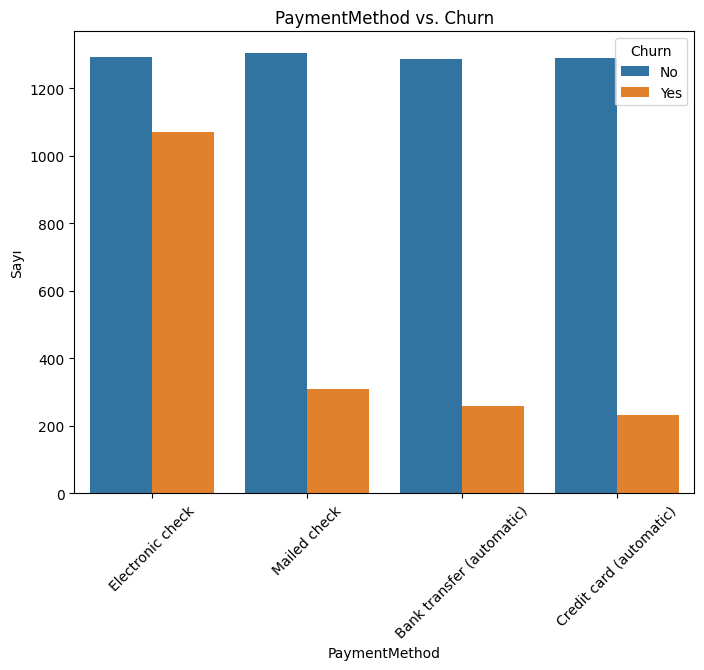

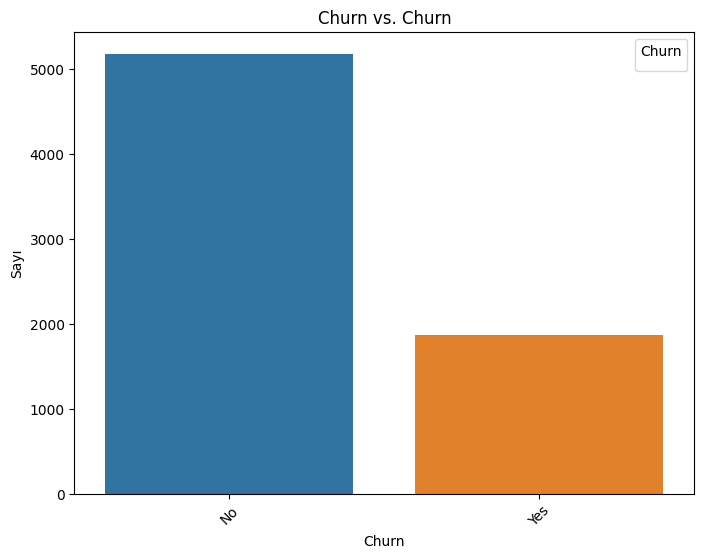

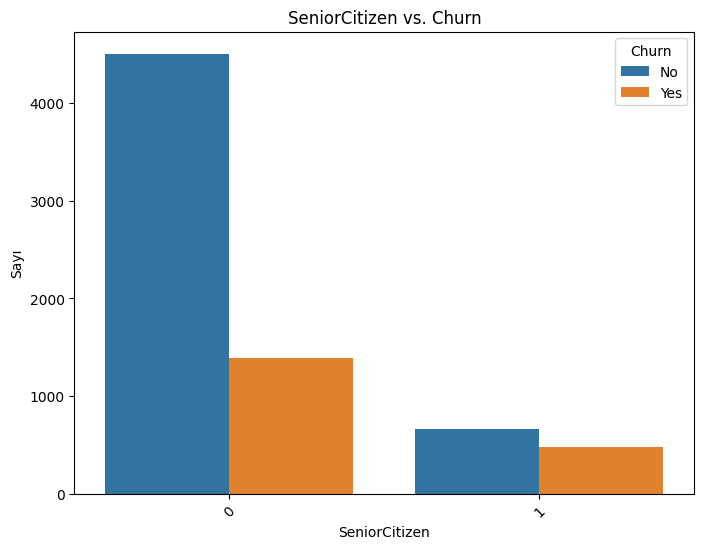

In [30]:
# Kategorik değişkenler ile hedef değişken incelemesininin yapılması:

import matplotlib.pyplot as plt
# Kategorik değişkenler ile hedef değişken incelemesini yapınız.
for col in cat_cols:
    plt.figure(figsize=(8, 6))
    sns.countplot(x=df[col], hue=df['Churn'])
    plt.title(f"{col} vs. Churn")
    plt.xlabel(col)
    plt.ylabel("Sayı")
    plt.xticks(rotation=45)
    plt.legend(title='Churn')
    plt.show()


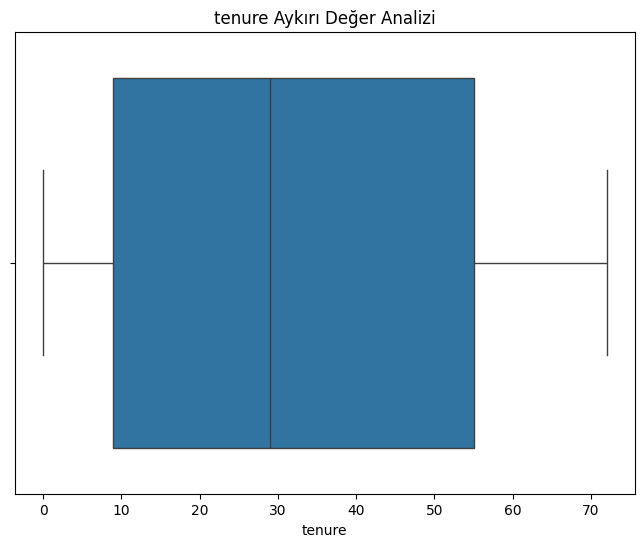

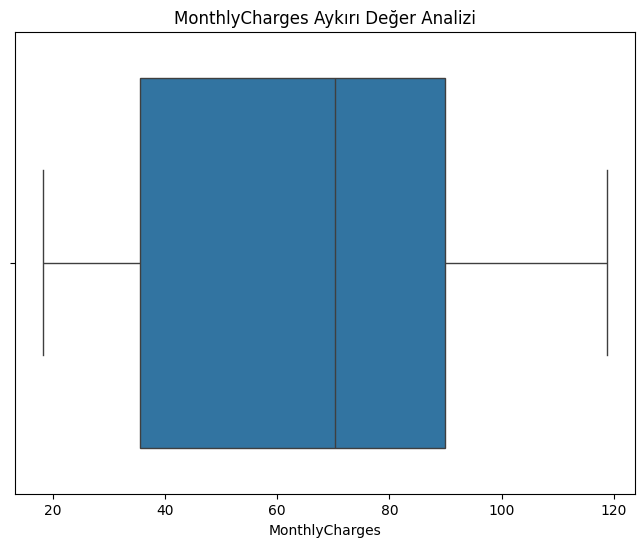

In [31]:
# Aykırı gözlem incelenmesi:

import matplotlib.pyplot as plt
# Aykırı değerleri görselleştirmek için boxplot kullanabilirsiniz.
for col in num_cols:
    plt.figure(figsize=(8, 6))
    sns.boxplot(x=df[col])
    plt.title(f"{col} Aykırı Değer Analizi")
    plt.xlabel(col)
    plt.show()


In [33]:
# Eksik ve aykırı gözlemler için gerekli işlemleri yapılması:

import numpy as np
# Eksik değerleri doldurma veya silme
df.dropna(inplace=True)  # Eksik değerleri içeren satırları silme

# Aykırı değerleri işlemek için IQR yöntemini kullanma
for col in num_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df[col] = np.clip(df[col], lower_bound, upper_bound)  # Aykırı değerleri sınırlarla değiştirme


In [36]:
# Yeni değişkenler oluşturulması

import pandas as pd
import numpy as np
# Toplam harcamaların aylık harcamalara oranını içeren yeni bir değişken oluşturma
df['MonthlyChargesRatio'] = df['TotalCharges'] / df['MonthlyCharges']

# Sözleşme süresine göre müşteri kategorilerini oluşturma
df['ContractCategory'] = pd.cut(df['tenure'], bins=[0, 12, 24, np.inf], labels=['Short-term', 'Mid-term', 'Long-term'])

# Ek hizmetlerin sayısını içeren yeni bir değişken oluşturma
df['AdditionalServices'] = (df[['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']] == 'Yes').sum(axis=1)


In [37]:
# Encoding işlemlerinin gerçekleştirilmesi

import pandas as pd
from sklearn.preprocessing import OneHotEncoder

# Kategorik değişkenleri seçme
cat_cols = ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
            'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
            'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
            'PaperlessBilling', 'PaymentMethod', 'ContractCategory']

# One-Hot Encoding işlemi
ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)
ohe_df = pd.DataFrame(ohe.fit_transform(df[cat_cols]))
ohe_df.columns = ohe.get_feature_names_out(cat_cols)

# One-Hot Encoding sonucunu orijinal veri çerçevesine ekleme
df = pd.concat([df, ohe_df], axis=1)

# Orijinal kategorik sütunları düşürme
df.drop(cat_cols, axis=1, inplace=True)


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [38]:
# Numerik değişkenler için standartlaştırma yapılması

from sklearn.preprocessing import StandardScaler

# Numerik sütunları seçme
num_cols = ['tenure', 'MonthlyCharges', 'TotalCharges', 'MonthlyChargesRatio', 'AdditionalServices']

# StandardScaler oluşturma
scaler = StandardScaler()

# Numerik sütunları ölçeklendirme
df[num_cols] = scaler.fit_transform(df[num_cols])


In [42]:
print(X_train.head())
print(X_train.dtypes)



      customerID  SeniorCitizen    tenure  MonthlyCharges  TotalCharges  \
2147  2023-VQFDL            0.0 -0.587601       -1.522353     -0.853477   
1628  6267-DCFFZ            1.0 -0.098673        0.839381      0.151724   
6083  1468-DEFNC            1.0  1.286622       -1.342854     -0.324119   
1367  4238-HFHSN            1.0  1.164390        0.576781      1.156595   
6765  5115-SQAAU            0.0  1.490341       -1.302966     -0.269080   

      MonthlyChargesRatio  AdditionalServices  gender_Female  gender_Male  \
2147            -0.572260           -1.103454            1.0          0.0   
1628            -0.132187           -0.020634            1.0          0.0   
6083             1.263024           -1.103454            1.0          0.0   
1367             1.109923           -0.562044            0.0          1.0   
6765             1.340238           -1.103454            1.0          0.0   

      Partner_No  ...  Contract_Two year  PaperlessBilling_No  \
2147         1.0  ...

In [44]:
# Veri çerçevesinden gereksiz sütunları çıkarılması
X = df.drop(columns=['customerID', 'Churn'])  # 'Churn' hedef değişkeni olarak bırakıldı
y = df['Churn']  # Hedef değişken

# Veriyi eğitim ve test setlerine ayırın
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [47]:
# 4 model kullanıp içinden en iyisini aldık

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# NaN değerleri kontrol edin ve silin
X_train.dropna(inplace=True)
y_train = y_train[X_train.index]  # y_train'i X_train ile aynı indekse sahip olacak şekilde filtreleyin

X_test.dropna(inplace=True)
y_test = y_test[X_test.index]  # y_test'i X_test ile aynı indekse sahip olacak şekilde filtreleyin

# Modelleri tanımlayın
models = [
    ('Logistic Regression', LogisticRegression()),
    ('Random Forest', RandomForestClassifier()),
    ('Support Vector Machine', SVC()),
    ('K-Nearest Neighbors', KNeighborsClassifier())
]

# Modelleri eğitin ve değerlendirin
best_model = None
best_accuracy = 0

for name, model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"{name} Accuracy: {accuracy}")

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = (name, model)

# En iyi modeli yazdırın
print(f"\nEn iyi model: {best_model[0]} with accuracy {best_accuracy}")


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy: 0.7884250474383302
Random Forest Accuracy: 0.7870018975332068
Support Vector Machine Accuracy: 0.7903225806451613
K-Nearest Neighbors Accuracy: 0.7485768500948766

En iyi model: Support Vector Machine with accuracy 0.7903225806451613


In [53]:
# en iyi değeri veren SVM ile hiperparametre optimizasyonu gerçekleştirdik ve bulunan hiperparametreler ile modeli tekrar kurduk

from sklearn.model_selection import GridSearchCV

# SVM için hiperparametre aralığını tanımlayın
param_grid = {'C': [0.1, 1, 10],
              'kernel': ['linear', 'rbf'],
              'gamma': ['scale', 'auto']}

# GridSearchCV kullanarak en iyi hiperparametreleri bulun
grid_search = GridSearchCV(SVC(), param_grid, cv=5)
grid_search.fit(X_train, y_train)

# En iyi hiperparametreleri yazdırın
print("En iyi hiperparametreler:", grid_search.best_params_)

# En iyi hiperparametreler ile SVM modelini tekrar kurun
best_svm = SVC(**grid_search.best_params_)
best_svm.fit(X_train, y_train)

# Test verileri üzerinde tahmin yapın
y_pred = best_svm.predict(X_test)

# Modelin doğruluğunu değerlendirin
accuracy = accuracy_score(y_test, y_pred)
print("Optimize edilmiş SVM Accuracy:", accuracy)


En iyi hiperparametreler: {'C': 1, 'gamma': 'auto', 'kernel': 'rbf'}
Optimize edilmiş SVM Accuracy: 0.7945920303605313


In [55]:
from sklearn.preprocessing import LabelEncoder

# Etiketleri dönüştürdük
label_encoder = LabelEncoder()
y_test_encoded = label_encoder.fit_transform(y_test)
y_pred_encoded = label_encoder.transform(y_pred)

# Hata Metriklerini hesapladık
accuracy = accuracy_score(y_test_encoded, y_pred_encoded)
roc_auc = roc_auc_score(y_test_encoded, y_pred_encoded)
recall = recall_score(y_test_encoded, y_pred_encoded)
precision = precision_score(y_test_encoded, y_pred_encoded)
conf_matrix = confusion_matrix(y_test_encoded, y_pred_encoded)

# Sonuçları yazdırdık
print("Optimize Edilmiş SVM Metrikleri:")
print("Accuracy:", accuracy)
print("ROC AUC:", roc_auc)
print("Recall:", recall)
print("Precision:", precision)
print("Confusion Matrix:\n", conf_matrix)



Optimize Edilmiş SVM Metrikleri:
Accuracy: 0.7945920303605313
ROC AUC: 0.6748391802377024
Recall: 0.4339622641509434
Precision: 0.6336088154269972
Confusion Matrix:
 [[1445  133]
 [ 300  230]]


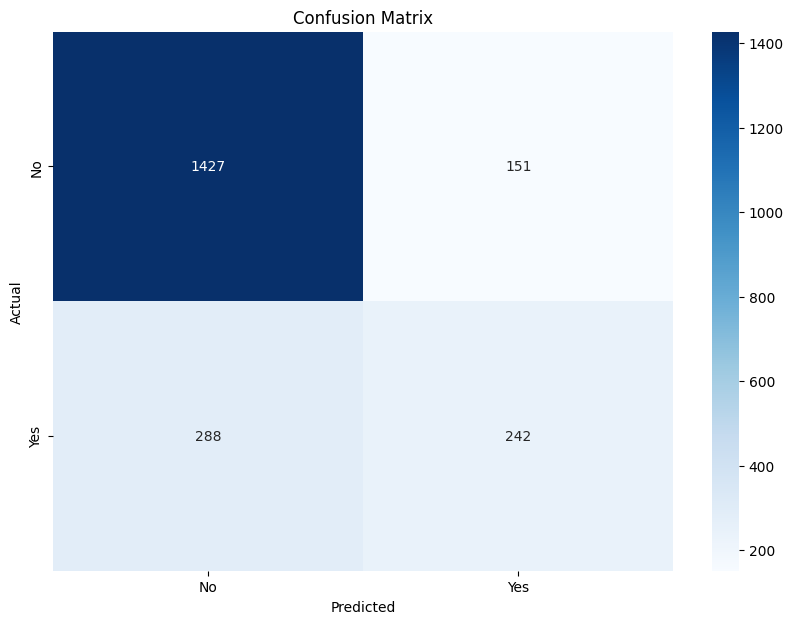

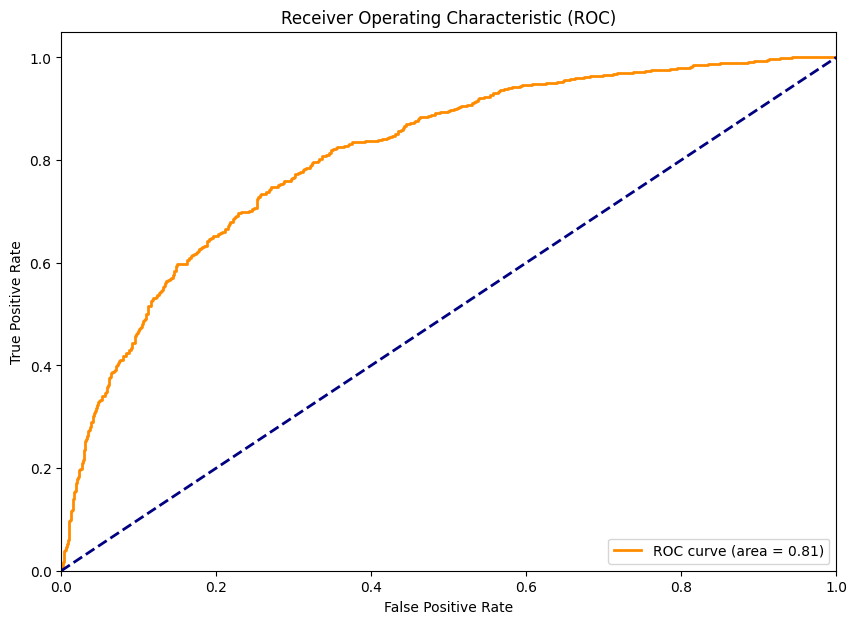

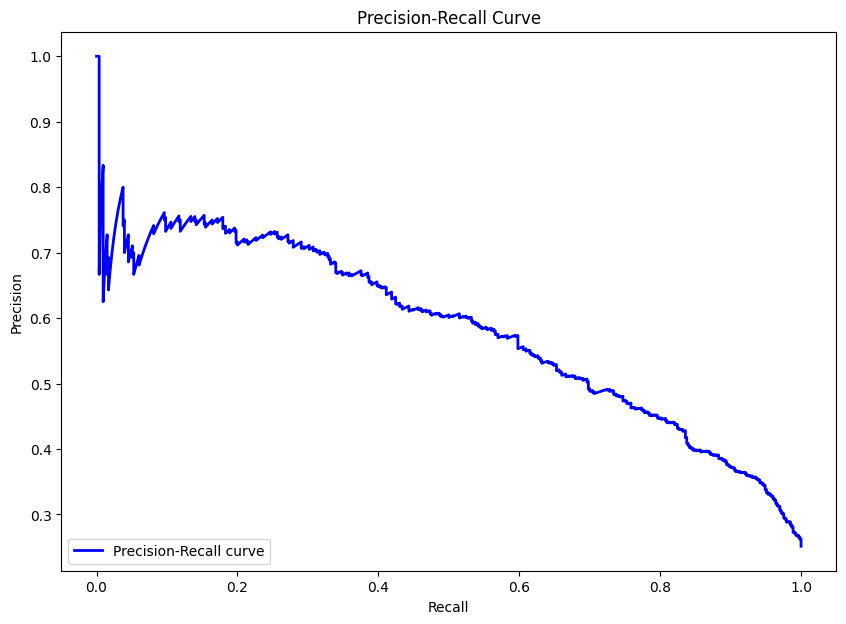

In [56]:
#Sonuçların Görselleştirilmesi
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, precision_recall_curve

# Confusion Matrix'i görselleştirin
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# ROC Curve'i görselleştirin
fpr, tpr, _ = roc_curve(y_test, y_pred_proba, pos_label='Yes')
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 7))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

# Precision-Recall Curve'i görselleştirin
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba, pos_label='Yes')

plt.figure(figsize=(10, 7))
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()
